In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing The Right Modules
just the importing stuff, if you're familiar with torch, you'll know what these are for

In [2]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torchvision.transforms as tt
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
%matplotlib inline
from torchvision.utils import save_image
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

# Getting our Data Ready
here we define our, path, image size, batch size and normalization stats for getting our data ready for processing

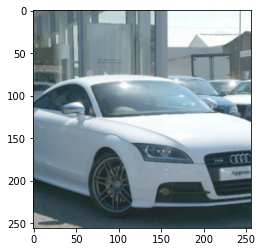

In [3]:
data_path = "input/stanford-cars-dataset/cars_train/cars_train"
image_size = 256
batch_size = 64
normstats = (0.,0.,0.),(1.,1.,1.)
transforms = tt.Compose([tt.Resize(image_size),#resize to make things uniform
                        tt.CenterCrop(image_size),#cropping to the center to avoid distortion
                        tt.ToTensor(),#to a tensor
                        tt.Normalize(*normstats)#normalizing in order to increase effectiveness of our GAN
                        ])
dataset = ImageFolder(data_path, transform = transforms)
img, _ = dataset[0]
plt.imshow(img.permute((1,2,0)))

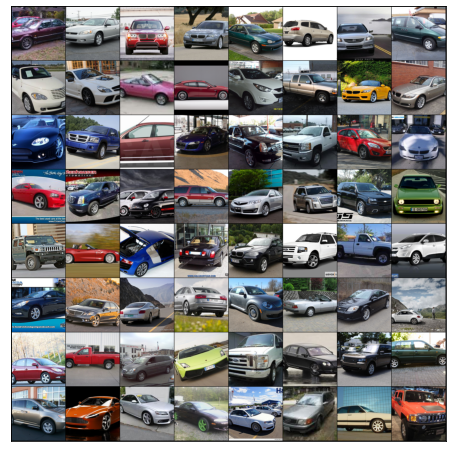

In [4]:
def denorm(img_tensors):
    return img_tensors * normstats[1][0] + normstats[0][0]

def show_batch(dl):#just to show one batch of our data
    for img, _ in dl:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(img[:64],nrow = 8).permute(1,2,0))
        break

def show_images(images):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]),ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(denorm(images.detach()[:64]),nrow = 8).permute(1,2,0))

dataload = DataLoader(dataset,batch_size,num_workers = 4,shuffle = True, pin_memory=True)#makes our data into batches
show_batch(dataload)

# GPU Time!
here we define classes that load stuff to our accelerator that would help us achieve faster epochs

In [5]:
def find_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device('cpu')

In [6]:
device = find_default_device()

In [7]:
device

device(type='cpu')

In [8]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    else:
        return data.to(device, non_blocking=True)

In [9]:
class DataloaderDeviced():
    def __init__(self,data,device):
        self.data = data
        self.device = device
    def __iter__(self):
        for b in self.data:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self.data)

In [10]:
dataload = DataloaderDeviced(dataload,device)

# Making our Discirminator
we have input images of size 3x256x256
we are now trying to define a discriminator network that would differentiate between fake and real images acting as the loss function to our generator.
<br>essentially:
<br>this guy is the guy who tells our generator how wrong his generated image is, based off which changes to the generated images are made

In [11]:
descriminator = nn.Sequential(
    #input size being of 3 channels, 256x256
    nn.Conv2d(3, 32 ,kernel_size = 3, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.1, inplace=True),
    #output size being of 32 channels, 128x128
    
    nn.Conv2d(32,64,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.1, inplace=True),
    #out 64x64x64
    
    nn.Conv2d(64,128,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.1, inplace = True),
    #out 128x32x32
    
    nn.Conv2d(128,256,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.1,inplace = True),
    #out 256x16x16
    
    nn.Conv2d(256,512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.1, inplace = True),
    #out 512x8x8
    
    nn.Conv2d(512,1024, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.1,inplace = True),
    #out 1024x4x4
    
    nn.Conv2d(1024,1,kernel_size = 4,stride = 1, padding = 0, bias = False),
    #out 1x1x1
    
    nn.Flatten(),
    nn.Sigmoid(),
    #final activation for T/F
)

descriminator.load_state_dict(torch.load("discweights4.pth"))
descriminator = to_device(descriminator,device)
descriminator

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1, inplace=True)
  (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.1, inplace=True)
  (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.1, inplace=True)
  (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.1, inplace=True)
  (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  

# Making our Generator
taking in a latent vector of size 128, we're going to generate an image of size 256x256.<br>
this is our generator, here, we take in a random tensor(a random value for imagining our random image), and then by the magic of transposed convolutions, we generate images.


In [12]:
latent_sz = 128

In [13]:
generator = nn.Sequential(
    #latent in 128x1x1
    nn.ConvTranspose2d(128,1024,kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.1, inplace=True),
    #out 1024x4x4
    
    nn.ConvTranspose2d(1024,512,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.1, inplace=True),
    #out 512x8x8
    
    nn.ConvTranspose2d(512,256,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.1, inplace=True),
    #out 256x16x16
    
    nn.ConvTranspose2d(256,128,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.1, inplace=True),
    #out 128x32x32
    
    nn.ConvTranspose2d(128,64,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.1, inplace=True),
    #out 64x64x64
    
    nn.ConvTranspose2d(64,32,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.1, inplace=True),
    #out 32x128x128
    
    nn.ConvTranspose2d(32,3,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()
    #out 3x256x256
    
)
generator.load_state_dict(torch.load("genweights4.pth"))
generator

Sequential(
  (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1, inplace=True)
  (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.1, inplace=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.1, inplace=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.1, inplace=True)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


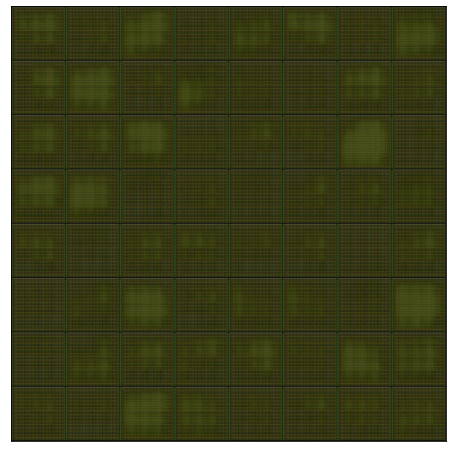

In [14]:
xb = torch.randn(batch_size,latent_sz,1,1,)
fake_images = generator(xb)
show_images(fake_images)
generator = to_device(generator,device)

# Training functions
### training our discriminator
Here's how we train a GAN, we first feed real images form our dataset to the discriminator(whose job is basically to tell if the generated image is fake or real),<br>
Ideally for images from our dataset, our discrimiator should return 'real'(1), so our target is sessentially 1<br>
<br>
We also generate fake images from our generator so that our discriminator knows what a 'fake' image is aswell, so here, our target is 'fake'(0).
<br>
Based off the outputs we recive, we backpropogate and updates the weights accordingly to recive the ideal outputs.

In [15]:
def train_discriminator(real_images,opt_d):
    
    opt_d.zero_grad()
    real_preds = descriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1,device = device)
    real_loss = F.binary_cross_entropy(real_preds,real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size,latent_sz,1,1, device = device)
    fake_images = generator(latent)
    
    fake_preds = descriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0),1,device = device)
    fake_loss = F.binary_cross_entropy(fake_preds,fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    loss = fake_loss+real_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(),real_score,fake_score

### training our generator
So we know that, given an input random tensor we recive an image from our generator, so we essentially generate a batch of images from our generator and give them to the discriminator, who then returns 1 or 0 depending if the image is real or not, Ideally we ****should**** be able to fool our discirminator, so the fake images we generate should return a value of 1(real).
<br>
based off what our discriminator returns, we then backpropogate and update the weights accordingly.

In [16]:
def train_generator(opt_g):
    opt_g.zero_grad()
    latent = torch.randn(batch_size,latent_sz, 1,1, device = device)
    images = generator(latent)
    
    targets = torch.ones(batch_size,1,device = device)
    score = descriminator(images)
    loss = F.binary_cross_entropy(score,targets)
    
    loss.backward()
    opt_g.step()
    
    return loss.item()

# Helper Functions to Save images

here we have helper functions that help us save images we generated in each training epoch

In [17]:
savedir = "gen"
os.makedirs(savedir, exist_ok = True)


In [18]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}e1.png'.format(index+90)
    save_image(denorm(fake_images), os.path.join(savedir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow((make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0)))

In [19]:
torch.manual_seed(64)
fixed_latent = torch.randn(batch_size, latent_sz, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0090e1.png


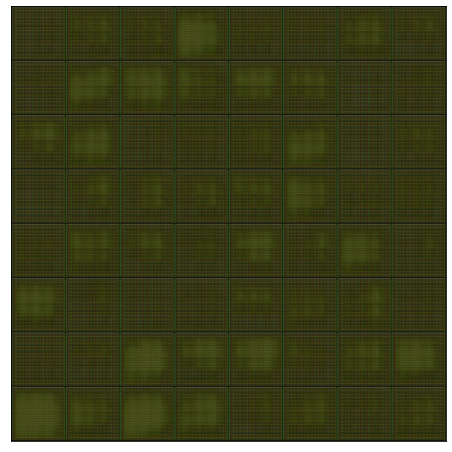

In [20]:
save_samples(0,fixed_latent)

# The Fit function
here we fit our images to the training dataset.

In [21]:
def fit(epochs, lr, start_idx = 1):
    loss_d =[]
    loss_g = []
    real_scores = []
    fake_scores = []
    
    opt_d = torch.optim.Adam(descriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for img, _ in tqdm(dataload):
            
            loss, real_score, fake_score = train_discriminator(img, opt_d)
            lossg = train_generator(opt_g)
            
        loss_d.append(loss)
        loss_g.append(lossg)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss, lossg, real_score, fake_score))
        
        save_samples(epoch+start_idx, fixed_latent, show=False)
        
    return loss_g,loss_d,real_scores,fake_scores

In [ ]:
lr = 5e-4
epochs = 2
history = fit(epochs,lr)

  0%|          | 0/128 [00:00<?, ?it/s]

# Saving our Weights
Yeah kaggle disconnects interactive sessions after a while,so we save and download the weights to see how the progress goes for the number of epochs we ran
<br>
we save the weights into .pth files

In [ ]:
torch.save(generator.state_dict(),"genweights4.pth")

In [ ]:
torch.save(descriminator.state_dict(),"discweights4.pth")

# Testing Our function
we generate a single image and then display it.
<br>
we can inspect it ourselves to see how real this image can get

In [ ]:
torch.manual_seed(94)
latent_test = torch.randn(1,latent_sz,1,1,device=device)
image = generator(latent_test)

In [ ]:
image=to_device(image, torch.device("cpu"))
b=image[0].permute(1,2,0).detach().numpy()
b.shape

In [ ]:
plt.imshow(b)

In [ ]:
#import jovian

In [ ]:
#jovian.commit(project=prjname,environment = None)
#jovian.commit(filename='cars_generator-Copy1.ipynb')

# That's it
Hope this experiment was informative and we could gain a few insights on how this dataset would work on our GAN